In [15]:
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np
from valleyfloor.process_topography import process_topography
from valleyfloor.utils import setup_wbt

from slopes.subbasins import label_subbasins
from slopes.hillslopes import label_hillslopes
from slopes.detrend import detrend
from slopes.utils import finite_unique
from slopes.Clubb2017_qq import Clubb2017_qq_threshold
from slopes.network_xsections import network_xsections, observe_values

In [2]:
wbt = setup_wbt("~/opt/WBT/", "../working_dir")

dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
flowlines = gpd.read_file("../data/input/flowlines.shp")

In [8]:
dataset, aligned_flowlines = process_topography(dem, flowlines, wbt)
aligned_flowlines = gpd.GeoSeries(aligned_flowlines['geometry'].values, index=aligned_flowlines['Stream_ID'])

subbasins = label_subbasins(dataset['flow_dir'], dataset['flow_acc'], dataset['flowpaths'], wbt)
hillslopes = label_hillslopes(dataset['flowpaths'], dataset['flow_dir'], subbasins, wbt)
dataset['hillslope'] = hillslopes
dataset['subbasins'] = subbasins

/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/slopes-hCrF487D-py3.10/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [53]:
for subbasin in finite_unique(dataset['subbasins']):
    condition = dataset['subbasins'] == subbasin
    slope = dataset['slope'].where(condition)
    slope = np.tan(np.radians(slope))
    hand = dataset['hand'].where(condition)

    slope_threshold = Clubb2017_qq_threshold(slope)
    hand_threshold = Clubb2017_qq_threshold(hand)
    print(subbasin, hand_threshold, slope_threshold)

1.0 303.7574462890625 None
2.0 444.383056640625 1.0890149
3.0 138.5498046875 0.91987807
4.0 254.8656005859375 1.4335946
5.0 144.42864990234375 0.90362906
6.0 88.588623046875 1.0709789
7.0 200.642333984375 None
9.0 154.54095458984375 None
10.0 102.5238037109375 1.0358111
11.0 121.53350830078125 1.1349301
12.0 159.32330322265625 1.0698949
13.0 84.86492919921875 1.2924889
14.0 94.30694580078125 1.175981


(<Axes: >, np.float64(94.30694580078125))

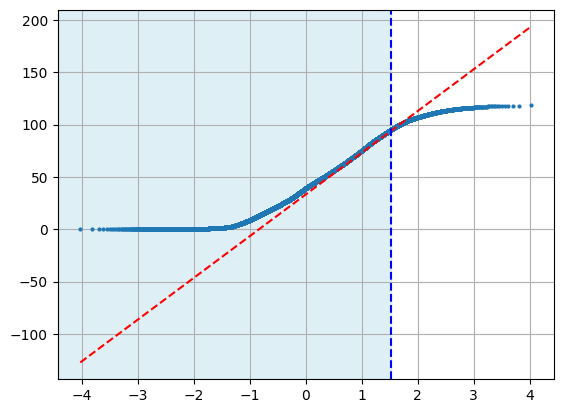

In [54]:
Clubb2017_qq_threshold(hand, plot=True)

(<Axes: >, np.float32(1.175981))

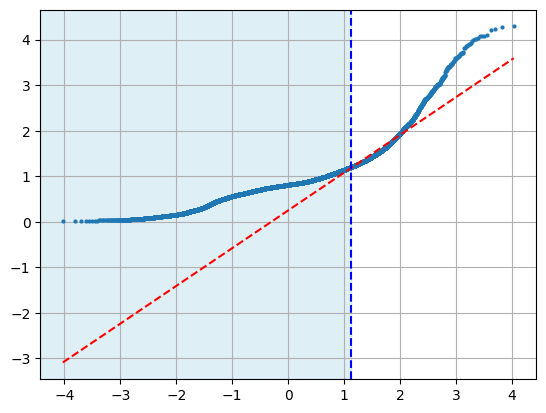

In [55]:
Clubb2017_qq_threshold(slope, plot=True)